# Przemysław Kaleta

Our goal is to build a model predicting wheter given person is married based on a few features and then to visualize model decisions.

Based on data from: https://data.stanford.edu/hcmst2017

Interesting app:
https://qz.com/quartzy/1551272/here-is-the-probability-you-will-break-up-with-your-partner/

In [387]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import xgboost as xgb
from collections import defaultdict

In [67]:
data = pd.read_stata("hcmts.dta")
print(len(data))
data.head()

3510


,CaseID,CASEID_NEW,qflag,weight1,weight1_freqwt,weight2,weight1a,weight1a_freqwt,weight_combo,weight_combo_freqwt,...,hcm2017q24_met_through_family,hcm2017q24_met_through_friend,hcm2017q24_met_through_as_nghbrs,hcm2017q24_met_as_through_cowork,w6_subject_race,interracial_5cat,partner_mother_yrsed,subject_mother_yrsed,partner_yrsed,subject_yrsed
0,2,2014039,Qualified,NaN,NaN,0.8945,NaN,NaN,0.277188,19240.0,...,no,no,no,no,White,no,12.0,14.0,12.0,14.0
1,3,2019003,Qualified,0.9078,71115.0,NaN,0.9026,70707.0,1.020621,70841.0,...,no,no,no,yes,White,no,12.0,16.0,17.0,17.0
2,5,2145527,Qualified,0.7205,56442.0,NaN,0.7164,56121.0,0.810074,56227.0,...,no,no,no,no,White,no,9.0,7.5,14.0,17.0
3,6,2648857,Qualified,1.2597,98682.0,1.3507,1.2524,98110.0,0.418556,29052.0,...,no,no,no,no,White,no,16.0,12.0,12.0,12.0
4,7,2623465,Qualified,0.8686,68044.0,NaN,0.8636,67652.0,0.976522,67781.0,...,no,no,yes,no,White,no,14.0,17.0,16.0,16.0


Explanations of variable names taken from:

https://stacks.stanford.edu/file/druid:vt073cc9067/HCMST_2017_fresh_Codeboodk_v1.1a.pdf

* Yes/no questions:
    * **Q5** Is [Partner name] the same sex as you? 
    * **Q25_2** Did you and [Partner name] attend the same high school?
    * **Q26_2** Did you and [Partner name] attend the same college or university?
    * **hcm2017q24_met_online** Met online
    
* Quantitative questions:
    * **w6_q9** partner age in 2017
    * **w6_q24_length** length of q24 how met answer in characters

## Selecting data

In [330]:
binary_variables = ["Q5", "Q25_2", "Q26_2",  "hcm2017q24_met_online"]
continuous_variables = ["w6_q9", "w6_q24_length"]
predicted_variables = ["S1"]
variables = binary_variables + continuous_variables + predicted_variables
mydata = data.loc[data.S1.notna(), variables]
len(mydata)

3510

In [331]:
mydata.head()

,Q5,Q25_2,Q26_2,hcm2017q24_met_online,w6_q9,w6_q24_length,S1
0,NaN,Different High School,NaN,yes,26.0,232.0,"No, I am not Married"
1,NaN,NaN,NaN,no,52.0,213.0,"Yes, I am Married"
2,NaN,NaN,NaN,yes,45.0,87.0,"Yes, I am Married"
3,NaN,Different High School,NaN,yes,26.0,80.0,"No, I am not Married"
4,NaN,NaN,NaN,no,59.0,648.0,"Yes, I am Married"


Let's check how many of our variables are unknown. It seems to be a big problem here.

In [332]:
mydata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3510 entries, 0 to 3509
Data columns (total 7 columns):
Q5                       468 non-null category
Q25_2                    538 non-null category
Q26_2                    202 non-null category
hcm2017q24_met_online    3394 non-null category
w6_q9                    3374 non-null float64
w6_q24_length            3394 non-null float32
S1                       3510 non-null category
dtypes: category(5), float32(1), float64(1)
memory usage: 86.2 KB


## Model fitting

In [333]:
# Dictionary with keys as columns of categorical variables 
# and values as functions which for a given code tell us what category it is
name_from_code = defaultdict(lambda: lambda x: x)

for column_name in binary_variables + predicted_variables:
    
    column = mydata[column_name].values
    
    def _name_from_code(x, col=column):
        return col.from_codes([x], col.categories)[0]
    
    name_from_code[column_name] = _name_from_code
    
    mydata[column_name] = column.codes

In [334]:
mydata.head()

,Q5,Q25_2,Q26_2,hcm2017q24_met_online,w6_q9,w6_q24_length,S1
0,-1,2,-1,1,26.0,232.0,1
1,-1,-1,-1,0,52.0,213.0,0
2,-1,-1,-1,1,45.0,87.0,0
3,-1,2,-1,1,26.0,80.0,1
4,-1,-1,-1,0,59.0,648.0,0


In [335]:
X, y = mydata.drop("S1", axis=1), mydata["S1"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [336]:
xgb_model = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 0, n_estimators = 100)

In [337]:
xgb_model.fit(X_train, y_train)

XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [338]:
y_pred = xgb_model.predict(X_test)

In [339]:
y_pred_train = xgb_model.predict(X_train)

In [340]:
def test_classifier(y_true, y_pred):
    n = len(y_true)
    print(f"Positive/negative percentages in population: {sum(y_true) / n} / {sum(y_true==0) / n}")
    print(f"Accuracy {sum(y_true == y_pred) / n}")
    print(f"F1 score: {f1_score(y_true, y_pred)}")

In [341]:
test_classifier(y_train, y_pred_train)

Positive/negative percentages in population: 0.405982905982906 / 0.594017094017094
Accuracy 0.8425925925925926
F1 score: 0.779


In [342]:
test_classifier(y_test, y_pred)

Positive/negative percentages in population: 0.405982905982906 / 0.594017094017094
Accuracy 0.8005698005698005
F1 score: 0.7107438016528925


## Ceteris Paribus profile

Let's try to make some plots showing how model prediction would change for different values of last two variables ("w6_q9" - partner age and "w6_q24_length" length of answer to the "how met" question.

First, we will take some random person from our dataset.

In [366]:
random.seed(123)
random_person = X_test.iloc[random.choice(range(0, len(X_test)))]
random_person = pd.DataFrame([random_person.values], columns=mydata.columns[:-1])

In [367]:
random_person

,Q5,Q25_2,Q26_2,hcm2017q24_met_online,w6_q9,w6_q24_length
0,-1.0,2.0,1.0,0.0,26.0,122.0


In [345]:
for colname, code in zip(random_person.columns, random_person.iloc[0]):
    print(colname, name_from_code[colname](code))

Q5 nan
Q25_2 Different High School
Q26_2 Did not attend same college or university
hcm2017q24_met_online no
w6_q9 26.0
w6_q24_length 122.0


In [346]:
xgb_model.predict(random_person), xgb_model.predict_proba(random_person)

(array([1], dtype=int8), array([[0.01540726, 0.98459274]], dtype=float32))

In [383]:
def get_proba(person, colname, colvalue):
    if colname not in X_train.columns:
        raise Exception("Wrong column name")
    person[colname] = colvalue
    return xgb_model.predict_proba(person)[0][0]

Let's check what is the range of our quantitative variables.

In [384]:
mydata[continuous_variables].describe()

,w6_q9,w6_q24_length
count,3374.000000,3394.000000
mean,48.777119,182.854446
std,17.119645,236.993225
min,-1.000000,0.000000
25%,34.000000,54.000000
50%,50.000000,124.000000
75%,62.000000,222.750000
max,95.000000,3855.000000


In [385]:
age_values = range(18, 96)
length_values = range(0, 300)

In [386]:
age_proba = [get_proba(random_person, "w6_q9", age) for age in age_values]
length_proba = [get_proba(random_person, "w6_q24_length", length) for length in length_values]

Text(0, 0.5, 'Marriage probability')

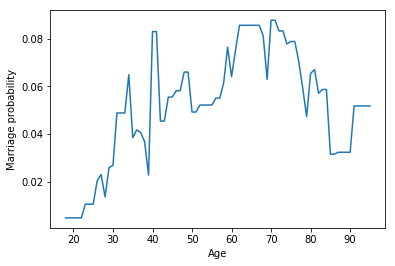

In [390]:
plt.plot(age_values, age_proba)
plt.xlabel("Age")
plt.ylabel("Marriage probability")

Text(0, 0.5, 'Marriage probability')

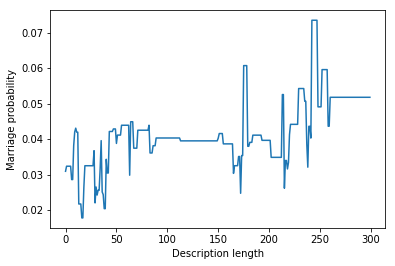

In [391]:
plt.plot(length_values, length_proba)
plt.xlabel("Description length")
plt.ylabel("Marriage probability")